In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import tensorboard
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

2022-11-15 11:38:24.523594: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import tensorflow as tf
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


2022-11-03 12:34:53.120917: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 12:34:53.121587: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-03 12:34:53.125007: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-03 12:34:53.155509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.635GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-11-03 12:34:53.155556: I tensorflow/stream_executor/platf

/tmp/ipykernel_102476/3810096837.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Z)


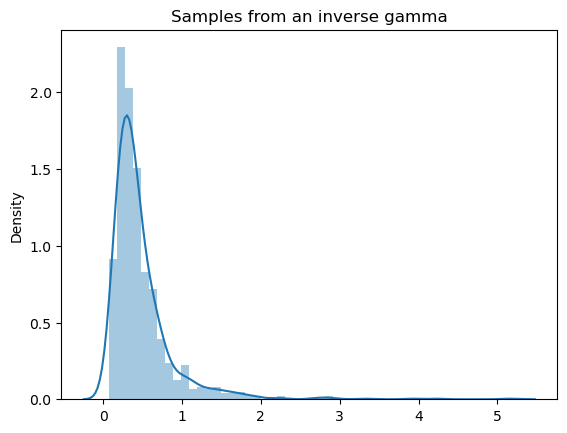

In [4]:
Z = tfd.InverseGamma(3,1).sample(1000,1)
sns.distplot(Z)
plt.title("Samples from an inverse gamma")
plt.show()



In [6]:
U = tfd.Gamma(8,1).sample(1000)
sns.distplot(U)
plt.title("Samples from an inverse gamma")
plt.show()

NotImplementedError: Cannot convert a symbolic Tensor (gradients/stateless_random_gamma/StatelessRandomGammaV2_grad/sub:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

(1000,)


/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



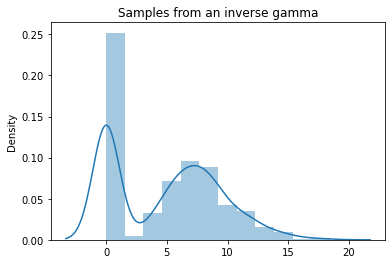

In [48]:
def esc_alpha(x):
    if x<0.3:
        return 0.5
    else :
        return 8
    

def esc_beta(x):
    if x<0.3:
        return 50
    else :
        return 1

alpha_beta = np.zeros((1000,2))
alpha_beta[...,0] = tf.map_fn(esc_alpha,Z)
alpha_beta[...,1] = tf.map_fn(esc_beta, Z)

X_new = tfd.Gamma(alpha_beta[...,0],alpha_beta[...,1]).sample()
print(X_new.shape)
sns.distplot(X_new)
plt.title("Samples from an inverse gamma")
plt.show()


/tmp/ipykernel_93760/3053886004.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_sort)


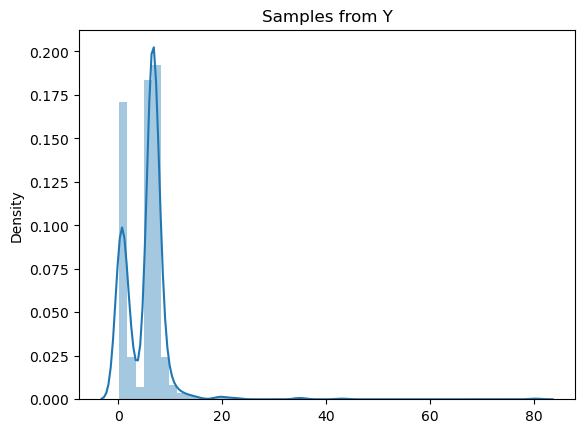

In [6]:
Ber = tfd.Bernoulli(probs=0.3, dtype ='float').sample(1000) 
IG1 = tfd.InverseGamma(concentration =1.8, scale = 1 ).sample(1000)
IG2 = tfd.InverseGamma(concentration =1.8, scale = 1 ).sample(1000)
Y = IG1*Ber +(6+IG2)*(1-Ber)

Y_sort=tf.sort(Y)
sns.distplot(Y_sort)
plt.title("Samples from Y")
plt.show()
train_dataset = Y[:250]
train_dataset = tf.reshape(train_dataset,[250,1])
eval_dataset = Y[250:]
eval_dataset = tf.reshape(eval_dataset,[750,1])

In [75]:
encoded_size = 1
input_shape =(1,)
nbparamsl = 2
nbparamsobs = 2


In [76]:
prior = tfd.InverseGamma(concentration =3, scale = 1 )

In [77]:
encoder3 = tfk.Sequential([
    tfkl.InputLayer(input_shape=[1]),
    tfkl.Dense(4,
               activation='relu'),
    tfkl.Dense(8,
               activation='relu'),
    tfkl.Dense(8,
               activation='relu'),
    tfkl.Dense(2,
               activation=None,
              name = 'inv_gamma_beta_posterior'),
    tfkl.Lambda(lambda x: tf.abs(x)+0.001),
])    


In [78]:
encoder3.add( tfpl.DistributionLambda(
    make_distribution_fn=lambda t: tfd.Normal(
        loc=t[...,0], scale=t[...,1]),
    activity_regularizer=tfpl.KLDivergenceRegularizer(prior)))
encoder3.add(tfkl.Reshape(target_shape=[1]))


In [79]:
encoder3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 4)                 8         
                                                                 
 dense_41 (Dense)            (None, 8)                 40        
                                                                 
 dense_42 (Dense)            (None, 8)                 72        
                                                                 
 inv_gamma_beta_posterior (D  (None, 2)                18        
 ense)                                                           
                                                                 
 lambda_10 (Lambda)          (None, 2)                 0         
                                                                 
 distribution_lambda_5 (Dist  ((None,),                0         
 ributionLambda)              (None,))               

In [80]:
decoder3 = tfk.Sequential([
    tfkl.InputLayer(input_shape=[1]),
    tfkl.Dense(4, use_bias=True, activation='relu'),
    tfkl.Dense(8, use_bias=True, activation='relu'),
    tfkl.Dense(8, use_bias=True, activation='relu'),
    tfkl.Dense(4, use_bias=True),
    tfkl.Lambda(lambda x: tf.abs(x)+0.001),
])

In [81]:
decoder3.add(tfkl.Dense(tfpl.IndependentNormal.params_size(1)))
decoder3.add(tfpl.IndependentNormal(1))


In [82]:
vae3 = tfk.Model(inputs=encoder3.inputs,
                outputs=decoder3(encoder3.outputs))

In [88]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae3.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
            loss=negative_log_likelihood)

In [91]:
vae3.fit(train_dataset,train_dataset,batch_size=16,epochs=100)

Epoch 1/100
16/16 [==============================] - 0s 5ms/step - loss: 3.9019
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 3.9784
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 3.7832
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 3.7688
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 4.0504
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 3.7335
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 4.0603
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 4.0039
Epoch 9/100
16/16 [==============================] - 0s 5ms/step - loss: 3.8970
Epoch 10/100
16/16 [==============================] - 0s 7ms/step - loss: 4.0519
Epoch 11/100
16/16 [==============================] - 0s 6ms/step - loss: 3.8722
Epoch 12/100
16/16 [==============================] - 0s 6ms/step - loss: 4.2319
Epoch 13/100
16/16 [=================

/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  after removing the cwd from sys.path.
/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


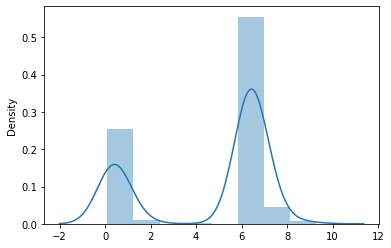

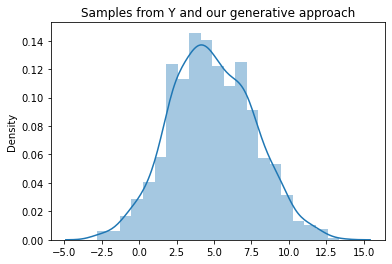

/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  if sys.path[0] == '':


<Figure size 432x288 with 0 Axes>

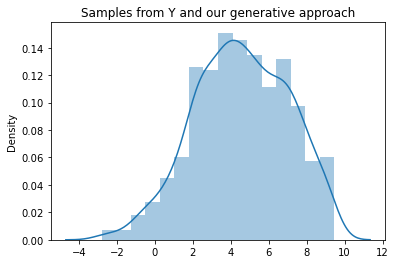

In [90]:
samples_y = Y
X_gen = prior.sample((1000))
samples_y_gen = tf.reshape(decoder3(X_gen),(1000,))
sns.distplot(samples_y)
plt.figure()
sns.distplot(samples_y_gen)
plt.title("Samples from Y and our generative approach")
plt.show()
plt.figure()
samples_y_gen_sort = tf.sort(samples_y_gen)
plt.figure()
sns.distplot(samples_y_gen_sort[:950])
plt.title("Samples from Y and our generative approach")
plt.show()

In [116]:
zeros_traindataset=tf.zeros(train_dataset.shape)

In [117]:
Y_input = tfk.Input(
    shape=[1], name="Y_train"
)  
zeros_input = tfk.Input([1], name="Zeros_train")
dist = tfkl.Dense(4, use_bias=True, activation='relu')(Y_input)
dist = tfkl.Dense(8, use_bias=True, activation='relu')(dist)
dist = tfkl.Dense(8, use_bias=True, activation='relu')(dist)
dist = tfkl.Dense(2, use_bias=True)(dist)
dist = tfkl.Lambda(lambda x: tf.abs(x)+0.001)(dist)
prior = tfkl.Dense(2,use_bias=True,activation=None, bias_initializer=tfk.initializers.Ones()
)(zeros_input)
prior = tfkl.Lambda(lambda x: tf.abs(x)+0.001)(prior)
#prior = tfpl.DistributionLambda(
 #   make_distribution_fn=lambda t: tfd.InverseGamma(
  #      concentration=t[... , 0], scale=t[...,1])
#)(prior)
prior = tfd.InverseGamma(concentration=prior[... , 0], scale = prior[..., 0])

posterior = tfpl.DistributionLambda(
    make_distribution_fn=lambda t: tfd.InverseGamma(
        concentration=t[... , 0], scale=t[...,1]),
    activity_regularizer=tfpl.KLDivergenceRegularizer(prior)
)(dist)
posterior = tfkl.Reshape(target_shape=[1])(posterior) 
print(posterior.shape)
encoder2 = tfk.Model(
    inputs=[Y_input,zeros_input],
    outputs=[posterior],
)

(None, 1)


In [118]:
encoder2.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Y_train (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_93 (Dense)               (None, 4)            8           ['Y_train[0][0]']                
                                                                                                  
 dense_94 (Dense)               (None, 8)            40          ['dense_93[0][0]']               
                                                                                                  
 dense_95 (Dense)               (None, 8)            72          ['dense_94[0][0]']               
                                                                                           

In [119]:
decoder2 = tfk.Sequential([
    tfkl.InputLayer(input_shape=[1]),
    tfkl.Dense(4, use_bias=True, activation='relu'),
    tfkl.Dense(8, use_bias=True, activation='relu'),
    tfkl.Dense(8, use_bias=True, activation='relu'),
    tfkl.Dense(4, use_bias=True),
    tfkl.Lambda(lambda x: tf.abs(x)+0.001),
])

In [120]:
decoder2.add(tfkl.Dense(tfpl.IndependentNormal.params_size(1)))
decoder2.add(tfpl.IndependentNormal(1))


In [121]:
decoder2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_98 (Dense)            (None, 4)                 8         
                                                                 
 dense_99 (Dense)            (None, 8)                 40        
                                                                 
 dense_100 (Dense)           (None, 8)                 72        
                                                                 
 dense_101 (Dense)           (None, 4)                 36        
                                                                 
 lambda_30 (Lambda)          (None, 4)                 0         
                                                                 
 dense_102 (Dense)           (None, 2)                 10        
                                                                 
 independent_normal_7 (Indep  ((None, 1),            

In [122]:
vae2 = tfk.Model(inputs=encoder2.inputs,
                outputs=decoder2(encoder2.outputs))

In [123]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae2.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
            loss=negative_log_likelihood)

In [124]:
vae2.fit(
    {"Y_train" : train_dataset, "Zeros_train" : zeros_traindataset},
    train_dataset,
    validation_data = ((eval_dataset,tf.zeros(eval_dataset.shape)),eval_dataset),
         batch_size=16,epochs=100)


Epoch 1/100


TypeError: in user code:

    File "/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/keras/engine/training.py", line 949, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses)
    File "/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 240, in __call__
        total_loss_metric_value, sample_weight=batch_dim)
    File "/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/keras/metrics/base_metric.py", line 450, in update_state  **
        sample_weight, values)
    File "/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/keras/engine/keras_tensor.py", line 255, in __array__
        f'You are passing {self}, an intermediate Keras symbolic input/output, '

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_3'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


In [9]:
alpha = [1., 1,2,2,2]
dist = tfd.Dirichlet(alpha)

Diri2 = tfd.Dirichlet([2,2,1,1,1])

print(Diri2.log_prob([0.5,0.5,0,0,0]))

tf.Tensor(5.192957, shape=(), dtype=float32)


In [72]:
import ot
def T(X,Y,n):
    MX = ot.dist(X,X,'sqeuclidean')
    MY = ot.dist(Y,Y,'sqeuclidean')
    T1 = (1/n**2)*np.sum(MX*MY)
    print(T1)
    T2 = (2/n**3)*np.sum(MX@MY)
    print(T2)
    T3 = (1/n**4)*np.sum(np.tensordot(MX,MY,axes=0))
    print(T3)
    return T1-T2+T3
    

In [115]:

mu1 = 0
sig1 = 2
mu2 = 0
sig2=1
n1 = 10
n2 = 10
d=5

mvn1 = tfd.MultivariateNormalDiag(
    loc=[mu1],
scale_diag=[sig1])
mvn2 = tfd.MultivariateNormalDiag(
    loc=[mu2],
scale_diag=[sig2])


s1 = mvn1.sample([n1,d])
s2 = mvn2.sample([n2,d])

s1 = tf.reshape(s1,(n1,d)).numpy()
s2=tf.reshape(s2,(n2,d)).numpy()
a, b = np.ones((n1,)) / n1, np.ones((n2,)) / n2 

In [116]:
Ms1 = ot.dist(s1,s1,'sqeuclidean')
Ms2 = ot.dist(s2,s2,'sqeuclidean')
U = np.tensordot(Ms1, Ms2, axes=0)
print(U.shape)
print(np.sum(U))
c = 0
for i in range(10):
    for j in range(10):
        c+=np.sum(Ms1[i,j]*Ms2)
print(c/(10**4))      

(10, 10, 10, 10)
3909761.2
390.97615205078125


In [117]:
from datetime import datetime
start=datetime.now()
print(T(s1,s2,10))
print(datetime.now()-start)

#Statements



452.4153515625
796.2014375
390.976125
47.190039062500034
0:00:00.009921


In [118]:
from statsmodels.distributions.empirical_distribution import ECDF

In [141]:
def tail_mod(f,n,x):
    return((n/n+1)*(f(x))+1/(n+1))

def L(X,Y,u):
    Nn = np.sum(X>u)
    m=Y.shape[0]
    fY=ECDF(Y[:,0])
    Xmax = np.maximum(X,u)
    Xu = np.minimum(Xmax,u)
    res = 1 + 1/Nn*(np.sum(np.log(tail_mod(fY,m,Xmax)/tail_mod(fY,m,Xu))))
    return(res)

def KLu(X,Y,u):
    return (-L(X,Y,u)-L(Y,X,u))
    

In [142]:
U = mvn1.sample(100)
print(U.shape)
V=mvn2.sample(100)

(100, 1)


In [143]:
f = ECDF(U[:,0])
print(f([0]))
print(tail_mod(f,100,0))

[0.51]
1.02990099009901


In [146]:
print(L(U,V,1))
print(KLu(U,V,1))

1.1221948683002871
-2.192934430676925
